In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

from matplotlib.pyplot import imshow


%matplotlib inline

In [2]:
# define the paths for the datasets
DATASET_PATH = 'C:/Users/ramon/brain_tumor_dataset/'
TRAIN_SET = DATASET_PATH + 'train/'
VAL_SET = DATASET_PATH + 'validation/'
TEST_SET = DATASET_PATH + 'test/'

In [123]:
def dataSummary(dataset):
    # print the number of images in the dataset
    print("The number of MRI Images labelled 'yes':", len(os.listdir(dataset + 'yes')))
    print("The number of MRI Images labelled 'no':", len(os.listdir(dataset + 'no')))

In [128]:
dataSummary(DATASET_PATH)

The number of MRI Images labelled 'yes': 155
The number of MRI Images labelled 'no': 98


In [5]:
def visualizeSamples():
    # visualize 9 samples from each class
    # create a new figure
    figureNo = plt.figure(figsize = (10, 10))
    figureNo.suptitle('TUMOR: NO')
    for (index, image) in enumerate(os.listdir(DATASET_PATH + 'no/')):
        if index >= 9:
            break
        plt.subplot(3, 3, index + 1) # 3x3 grid
        image = plt.imread(DATASET_PATH + 'no/' + image)
        plt.imshow(image, cmap = "gray")
        plt.axis("off")

    figureYes = plt.figure(figsize = (10, 10))
    figureYes.suptitle('TUMOR: YES')
    for (index, image) in enumerate(os.listdir(DATASET_PATH + 'yes/')):
        if index >= 9:
            break
        plt.subplot(3, 3, index + 1)
        image = plt.imread(DATASET_PATH + 'yes/' + image)
        plt.imshow(image, cmap = "gray")
        plt.axis("off")

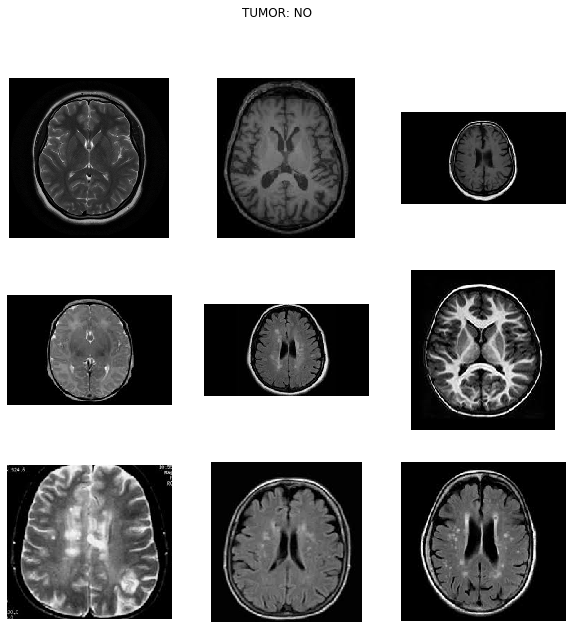

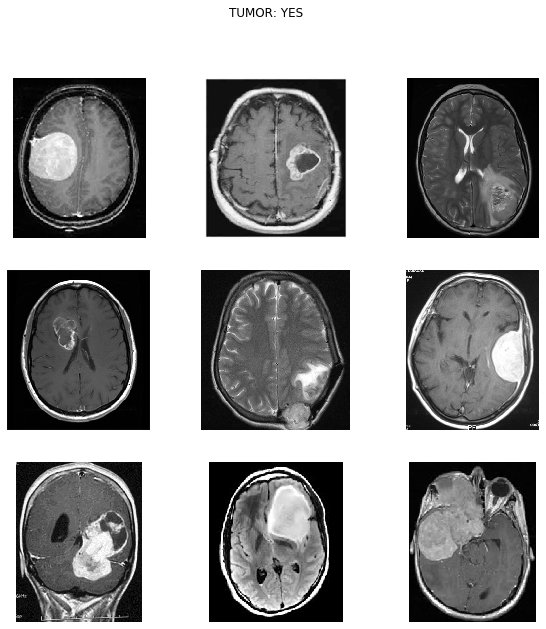

In [128]:
visualizeSamples()

In [3]:
# split the data into directories (train, validation, test)
def splitData(dataset, trainPercent):
    directories = {'test', 'validation', 'train'}
    # create e new directory for each category
    for directory in directories:
        os.mkdir(dataset + directory + '/')
        os.mkdir(dataset + directory + '/' + 'no/')
        os.mkdir(dataset + directory + '/' + 'yes/')
    
    # the percentage of the validation set
    valPercent = (1 - trainPercent) / 2
    
    labels = {'no', 'yes'}
    for label in labels:
        NUMBER_IMAGES = len(os.listdir(dataset + label))
        for(imageIndex, fileName) in enumerate(os.listdir(dataset + label)):
            currentImagePath = dataset + label + '/' + fileName
            # if the image is in the first NUMBER_IMAGES * trainPercent images, copy it to the training directory
            if imageIndex < int(NUMBER_IMAGES * trainPercent):
                shutil.copy(currentImagePath, dataset + 'train/' + label)
            # if the image is in the next NUMBER_IMAGES * valPercent images, copy it to the validation directory
            elif imageIndex >= NUMBER_IMAGES * trainPercent and imageIndex < NUMBER_IMAGES * (trainPercent + valPercent):
                shutil.copy(currentImagePath, dataset + 'validation/' + label)
            # if the image is in the remaining part, copy it to the testing directory
            else:
                shutil.copy(currentImagePath, dataset + 'test/' + label)

In [2]:
def loadData(trainSet, valSet, testSet):
    batchSize = 16
    # create a data generator, normalize the pixels values
    dataGenerator = ImageDataGenerator(rescale = 1./255)
    # create iterators for every dataset
    # every image will be resized to 150x150, use class_mode = binary, as we have 2 classes, and batch_size = 16
    # the list of classes will be automatically inferred from the subdirectory structure in the directory provided,
    # the order of the classes will determine the label (0/1)
    trainGenerator = dataGenerator.flow_from_directory(trainSet, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    valGenerator = dataGenerator.flow_from_directory(valSet, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    testGenerator = dataGenerator.flow_from_directory(testSet, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    
    return trainGenerator, valGenerator, testGenerator

In [6]:
def brainModel():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (150, 150, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # add the fully-connected layers
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
    
    return model

In [7]:
model = brainModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
__________

In [4]:
def train(model, trainGenerator, valGenerator, saveFile):
    
    history = model.fit_generator(
            trainGenerator,
            epochs = 50,
            validation_data = valGenerator)
    model.save(saveFile)
    
    return history

In [ ]:
# split the data in 80/10/10
splitData(DATASET_PATH, 0.8)
trainGenerator, valGenerator, testGenerator = loadData(TRAIN_SET, VAL_SET, TEST_SET)
model = brainModel()
# train the model and save it to model1
history = train(model, trainGenerator, valGenerator, 'model1')

In [14]:
def evaluateModel(model, testGenerator):
    predictions = model.evaluate_generator(testGenerator)
    print ("Loss = " + str(predictions[0]))
    print ("Test Accuracy = " + str(predictions[1]))

In [12]:
trainGenerator, valGenerator, testGenerator = loadData(TRAIN_SET, VAL_SET, TEST_SET)
model = load_model('model1')
evaluateModel(model, testGenerator)

Found 202 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Loss = 0.3748185336589813
Test Accuracy = 0.92


In [15]:
def plotPerformance(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)
    
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label = 'Train set')
    plt.plot(epochs_range, val_accuracy, label = 'Validation set')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train set')
    plt.plot(epochs_range, val_loss, label='Validation set')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

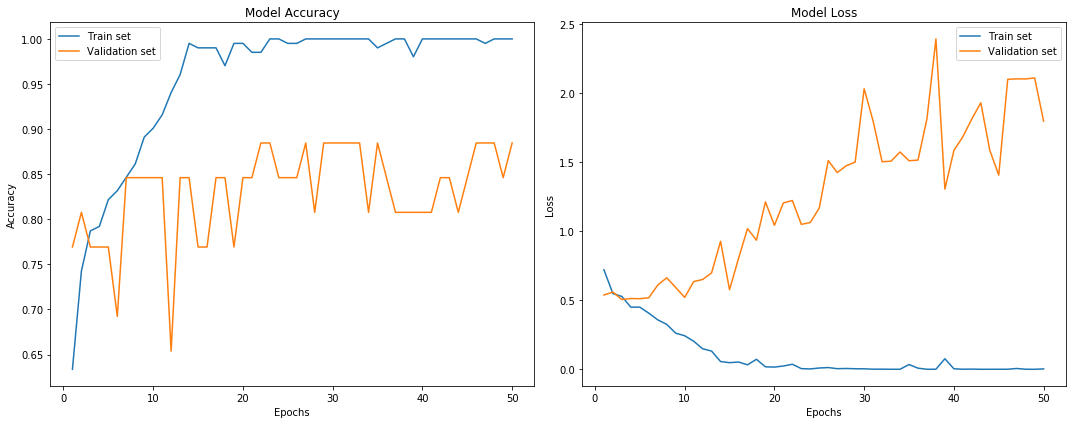

In [147]:
plotPerformance(history)

In [25]:
# The model1 is overfitting, as the training loss is low, but validation loss is high
# More data will help

In [16]:
def predictImage(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    # transform the image into an array
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.0
    img = plt.imread(img_path)
    plt.imshow(img, cmap = "gray")
    plt.axis("off")
    
    print("class prediction (% tumor) = ")
    print(model.predict(x)[0][0])
    if(model.predict(x)[0][0] >= 0.5):
        print("Classified as YES")
    else:
        print("Classified as NO")

class prediction (% tumor) = 
5.482316e-13
Classified as NO


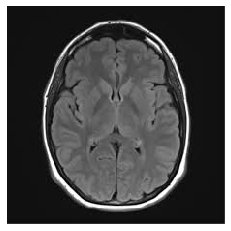

In [17]:
image_path_no = TEST_SET + 'no/no 923.jpg'
predictImage(model, image_path_no)

class prediction (% tumor) = 
1.0
Classified as YES


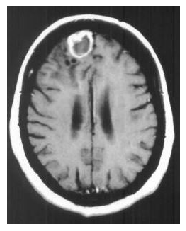

In [18]:
image_path_yes = TEST_SET + 'yes/Y85.jpg'
predictImage(model, image_path_yes)

In [10]:
# we will augment the data and see the results we obtain using more data
DATASET_PATH_AUG = 'C:/Users/ramon/brain_tumor_dataset_augmented/'
TRAIN_SET_AUG = DATASET_PATH_AUG + 'train/'
VAL_SET_AUG = DATASET_PATH_AUG + 'validation/'
TEST_SET_AUG = DATASET_PATH_AUG + 'test/'

In [33]:
def augmentDataFromFile(source, dest, n_generated_images):
    dataGenerator = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    # generate for each file another n_generated_images
    for filename in os.listdir(source):
        img = cv2.imread(source + filename)
        img = img.reshape((1,)+img.shape)
        # prefix of the names for the generated images
        save_prefix = 'aug_' + filename[:-5]
        # generate 'n_generated_samples' sample images
        index = 0
        for batch in dataGenerator.flow(x = img, batch_size = 1, save_to_dir = dest, 
                                           save_prefix = save_prefix, save_format='jpg'):
            index += 1
            if index > n_generated_images:
                break

In [41]:
def loadAugmentedData(trainSetAug, valSetAug, testSetAug):
    batchSize = 16
    dataGenerator = ImageDataGenerator(
        rotation_range = 20,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True)
    dataGeneratorValTest = ImageDataGenerator(rescale = 1./255)
    trainGenerator = dataGenerator.flow_from_directory(trainSetAug, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    valGenerator = dataGeneratorValTest.flow_from_directory(valSetAug, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    testGenerator = dataGeneratorValTest.flow_from_directory(testSetAug, target_size = (150, 150), class_mode = 'binary', batch_size = batchSize)
    
    return trainGenerator, valGenerator, testGenerator

In [31]:
def augmentData(datasetPathAug):
    # create a new big directory for the augmented data and directories for each class
    os.mkdir(datasetPathAug)
    os.mkdir(datasetPathAug + 'yes/')
    os.mkdir(datasetPathAug + 'no/')
    # use a slightly greater number for the 'no' examples in order to solve the Class Imbalance problem
    augmentDataFromFile(DATASET_PATH + 'no/', datasetPathAug + 'no/', 20)
    augmentDataFromFile(DATASET_PATH + 'yes/', datasetPathAug + 'yes/', 12)

In [130]:
augmentData(DATASET_PATH_AUG)
splitData(DATASET_PATH_AUG, 0.8)
dataSummary(DATASET_PATH_AUG)

The number of MRI Images labelled 'yes': 2007
The number of MRI Images labelled 'no': 2050


In [12]:
trainGeneratorAug, valGeneratorAug, testGeneratorAug = loadData(TRAIN_SET_AUG, VAL_SET_AUG, TEST_SET_AUG)

Found 3245 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Found 406 images belonging to 2 classes.


In [14]:
model2 = brainModel()
history2 = train(model2, trainGeneratorAug, valGeneratorAug, 'model2')

Epoch 1/50
203/203 [==============================] - 53s 262ms/step - loss: 0.5721 - acc: 0.7119 - val_loss: 0.3522 - val_acc: 0.8867
Epoch 2/50
203/203 [==============================] - 49s 243ms/step - loss: 0.4764 - acc: 0.7852 - val_loss: 0.3327 - val_acc: 0.8793
Epoch 3/50
203/203 [==============================] - 48s 237ms/step - loss: 0.3975 - acc: 0.8296 - val_loss: 0.3303 - val_acc: 0.8448
Epoch 4/50
203/203 [==============================] - 49s 241ms/step - loss: 0.3271 - acc: 0.8598 - val_loss: 0.2242 - val_acc: 0.9064
Epoch 5/50
203/203 [==============================] - 49s 240ms/step - loss: 0.2673 - acc: 0.8940 - val_loss: 0.2277 - val_acc: 0.8892
Epoch 6/50
203/203 [==============================] - 46s 225ms/step - loss: 0.2204 - acc: 0.9122 - val_loss: 0.2804 - val_acc: 0.8842
Epoch 7/50
203/203 [==============================] - 52s 258ms/step - loss: 0.1725 - acc: 0.9319 - val_loss: 0.1664 - val_acc: 0.9286
Epoch 8/50
203/203 [==============================] - 5

In [19]:
trainGeneratorAug, valGeneratorAug, testGeneratorAug = loadData(TRAIN_SET_AUG, VAL_SET_AUG, TEST_SET_AUG)
model2 = load_model('model2')
evaluateModel(model2, testGeneratorAug)

Found 3245 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Found 406 images belonging to 2 classes.
Loss = 1.8266298948572233
Test Accuracy = 0.773399


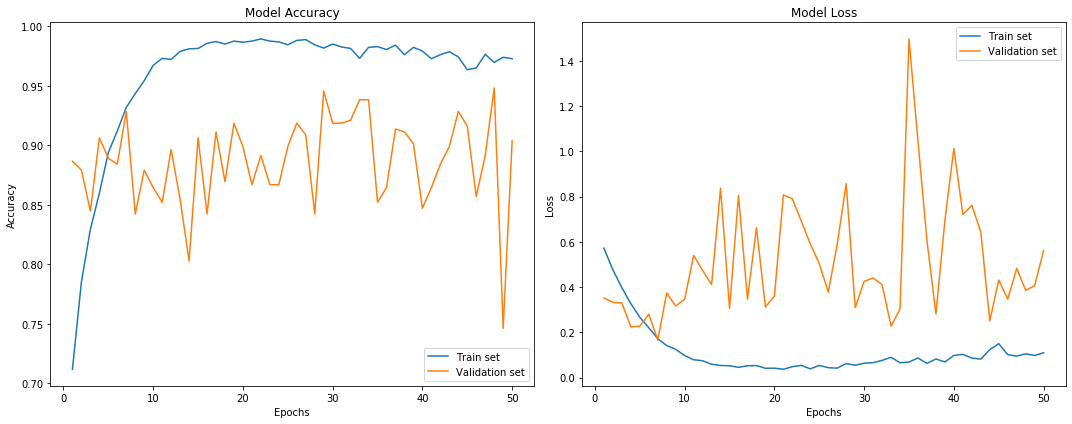

In [21]:
plotPerformance(history2)

class prediction (% tumor) = 
0.9828692
Classified as YES


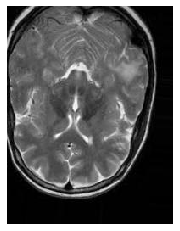

In [22]:
# false positive
image_path_no = TEST_SET_AUG + 'no/aug_N_0_1041.jpg'
predictImage(model2, image_path_no)

class prediction (% tumor) = 
1.3659112e-21
Classified as NO


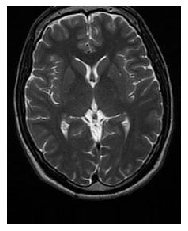

In [23]:
image_path_no = TEST_SET_AUG + 'no/aug_N_0_1346.jpg'
predictImage(model2, image_path_no)

class prediction (% tumor) = 
0.9625436
Classified as YES


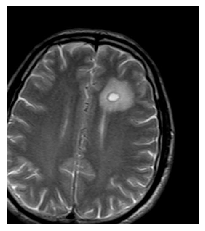

In [24]:
image_path_yes = TEST_SET_AUG + 'yes/aug_Y_0_31.jpg'
predictImage(model2, image_path_yes)

class prediction (% tumor) = 
0.9999999
Classified as YES


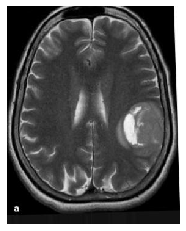

In [25]:
image_path_yes = TEST_SET_AUG + 'yes/aug_Y9_0_483.jpg'
predictImage(model2, image_path_yes)

In [26]:
# The training and validation loss are now closer on the plot
# We will use early stopping, given that model2 is also overfitting
# The training loss looks like a good fit, but the validation loss shows noisy movements in the plot
# This means that the validation data is unrepresentative (does not provide sufficient information to evaluate the model)
# The data will be split now in 60/20/20

In [26]:
# define a new train function using EarlyStopping
def trainEarlyStopping(model, trainGenerator, valGenerator, saveFile):
    # use EarlyStopping - stop when the monitored metric(validation accuracy) is no longer improving
    earlyStopping = EarlyStopping(
                    monitor = 'val_acc',
                    mode = 'max',
                    patience = 6)
    history = model.fit_generator(
            trainGenerator,
            epochs = 50,
            validation_data = valGenerator,
            callbacks = [earlyStopping])
    model.save(saveFile)
    
    return history

In [7]:
# splitData and augment it
DATASET_PATH_AUG_2 = 'C:/Users/ramon/brain_tumor_dataset_augmented_2/'
TRAIN_SET_AUG_2 = DATASET_PATH_AUG_2 + 'train/'
VAL_SET_AUG_2 = DATASET_PATH_AUG_2 + 'validation/'
TEST_SET_AUG_2 = DATASET_PATH_AUG_2 + 'test/'

augmentData(DATASET_PATH_AUG_2)
splitData(DATASET_PATH_AUG_2, 0.6)

In [33]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model3 = brainModel()
history3 = trainEarlyStopping(model3, trainGeneratorAugES, valGeneratorAugES, 'model3')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 43s 283ms/step - loss: 0.5925 - acc: 0.7002 - val_loss: 0.5065 - val_acc: 0.7750
Epoch 2/50
152/152 [==============================] - 41s 267ms/step - loss: 0.4985 - acc: 0.7657 - val_loss: 0.5118 - val_acc: 0.7676
Epoch 3/50
152/152 [==============================] - 40s 260ms/step - loss: 0.4341 - acc: 0.8089 - val_loss: 0.5046 - val_acc: 0.7614
Epoch 4/50
152/152 [==============================] - 43s 282ms/step - loss: 0.3578 - acc: 0.8521 - val_loss: 0.5232 - val_acc: 0.7800
Epoch 5/50
152/152 [==============================] - 40s 266ms/step - loss: 0.2951 - acc: 0.8785 - val_loss: 0.4734 - val_acc: 0.8121
Epoch 6/50
152/152 [==============================] - 41s 270ms/step - loss: 0.2385 - acc: 0.8966 - val_loss: 0.5392 - val_acc: 0.8381
Epoch 7/50
152/152 [==============================] - 41s 270ms/st

In [34]:
evaluateModel(model3, testGeneratorAugES)

Loss = 1.4156370146893988
Test Accuracy = 0.7891492


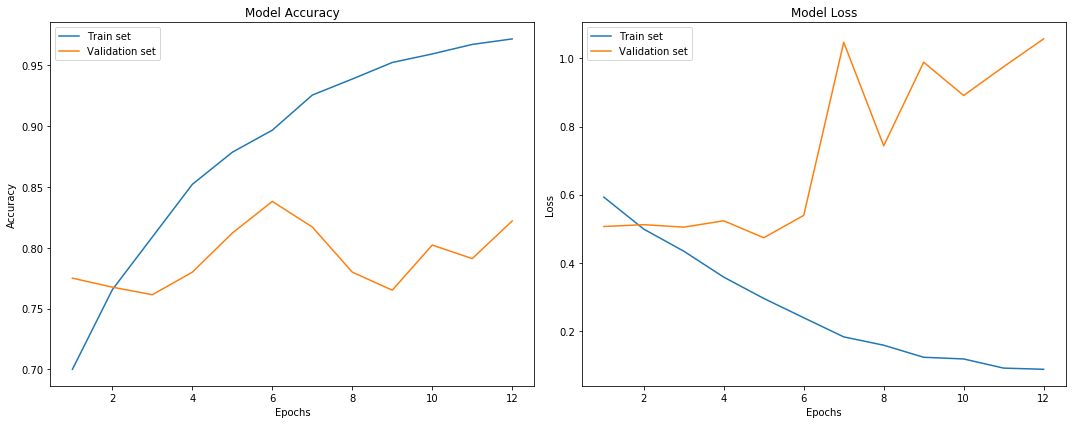

In [35]:
plotPerformance(history3)

class prediction (% tumor) = 
0.12499419
Classified as NO


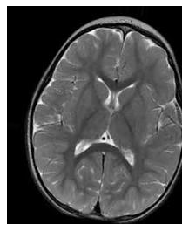

In [36]:
image_path_no = TEST_SET_AUG_2 + 'no/aug_N_0_743.jpg'
predictImage(model3, image_path_no)

class prediction (% tumor) = 
0.28917342
Classified as NO


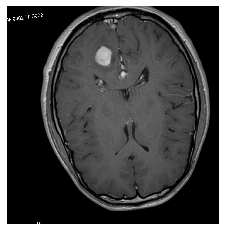

In [37]:
image_path_yes = TEST_SET_AUG_2 + 'yes/aug_Y_0_976.jpg'
predictImage(model3, image_path_yes)

In [37]:
def trainEarlyStoppingValLoss(model, trainGenerator, valGenerator, saveFile):
    # use EarlyStopping - stop when the monitored metric(validation accuracy) is no longer improving
    earlyStopping = EarlyStopping(
                    monitor = 'val_loss',
                    mode = 'min',
                    patience = 6)
    history = model.fit_generator(
            trainGenerator,
            #steps_per_epoch = 50, # 2000 // 16
            epochs = 50,
            validation_data = valGenerator,
            #validation_steps = 25,
            callbacks = [earlyStopping]) # 800//16
    model.save(saveFile)
    
    return history

In [43]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model4 = brainModel()
history4 = trainEarlyStoppingValLoss(model4, trainGeneratorAugES, valGeneratorAugES, 'model4')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 45s 293ms/step - loss: 0.5780 - acc: 0.6965 - val_loss: 0.5064 - val_acc: 0.7812
Epoch 2/50
152/152 [==============================] - 41s 270ms/step - loss: 0.4859 - acc: 0.7797 - val_loss: 0.5068 - val_acc: 0.7787
Epoch 3/50
152/152 [==============================] - 40s 264ms/step - loss: 0.4279 - acc: 0.8035 - val_loss: 0.5574 - val_acc: 0.7651
Epoch 4/50
152/152 [==============================] - 41s 267ms/step - loss: 0.3527 - acc: 0.8488 - val_loss: 0.5988 - val_acc: 0.7874
Epoch 5/50
152/152 [==============================] - 39s 257ms/step - loss: 0.2714 - acc: 0.8876 - val_loss: 0.7279 - val_acc: 0.7689
Epoch 6/50
152/152 [==============================] - 40s 262ms/step - loss: 0.2297 - acc: 0.9053 - val_loss: 0.6733 - val_acc: 0.7960
Epoch 7/50
152/152 [==============================] - 39s 254ms/st

In [44]:
evaluateModel(model4, testGeneratorAugES)

Loss = 1.349766315198412
Test Accuracy = 0.75092477


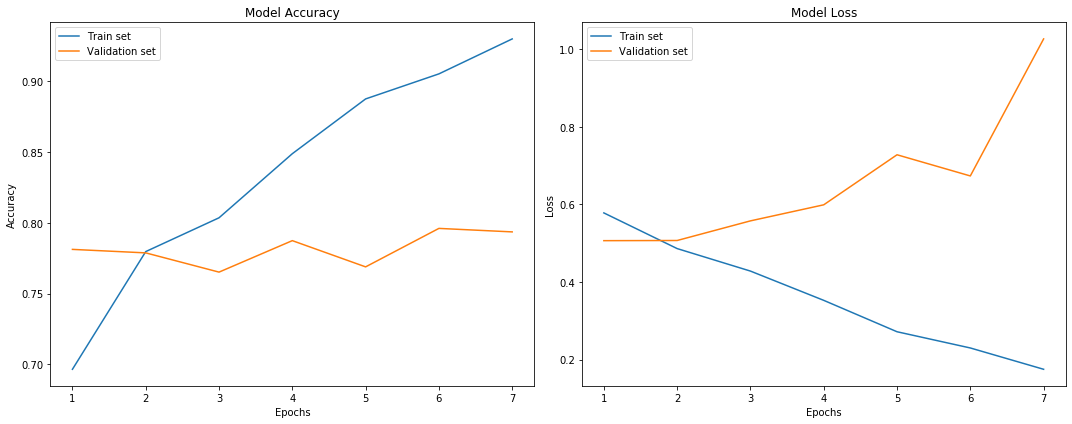

In [46]:
plotPerformance(history4)

In [9]:
# Try a different CNN Architecture

In [10]:
def brainModel2():
    model = Sequential()
    model.add(Conv2D(96, kernel_size = (11, 11), strides = (4, 4), input_shape = (150, 150, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides = (2, 2)))
    
    model.add(Conv2D(256, kernel_size = (5, 5), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2,2)))
    
    model.add(Conv2D(384, kernel_size = (3, 3), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(384, kernel_size = (1, 1), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size = (1, 1), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2,2)))
    
    # add the fully-connected layers
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
    
    return model

In [50]:
brainModel2().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 35, 35, 96)        34944     
_________________________________________________________________
activation_36 (Activation)   (None, 35, 35, 96)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 35, 35, 96)        384       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 17, 17, 256)       614656    
_________________________________________________________________
activation_37 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 17, 17, 256)       1024      
__________

In [51]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model5 = brainModel2()
history5 = trainEarlyStopping(model5, trainGeneratorAugES, valGeneratorAugES, 'model5')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 128s 843ms/step - loss: 0.9179 - acc: 0.7224 - val_loss: 0.5340 - val_acc: 0.6663
Epoch 2/50
152/152 [==============================] - 118s 777ms/step - loss: 0.3353 - acc: 0.8521 - val_loss: 0.2996 - val_acc: 0.8665
Epoch 3/50
152/152 [==============================] - 119s 781ms/step - loss: 0.2222 - acc: 0.9114 - val_loss: 0.2957 - val_acc: 0.9234
Epoch 4/50
152/152 [==============================] - 108s 712ms/step - loss: 0.1631 - acc: 0.9366 - val_loss: 0.2165 - val_acc: 0.9048
Epoch 5/50
152/152 [==============================] - 107s 704ms/step - loss: 0.1267 - acc: 0.9444 - val_loss: 0.3057 - val_acc: 0.8863
Epoch 6/50
152/152 [==============================] - 110s 723ms/step - loss: 0.1165 - acc: 0.9555 - val_loss: 0.5382 - val_acc: 0.7936
Epoch 7/50
152/152 [==============================] - 110s 7

In [52]:
evaluateModel(model5, testGeneratorAugES)

Loss = 1.1586264412777096
Test Accuracy = 0.8323058


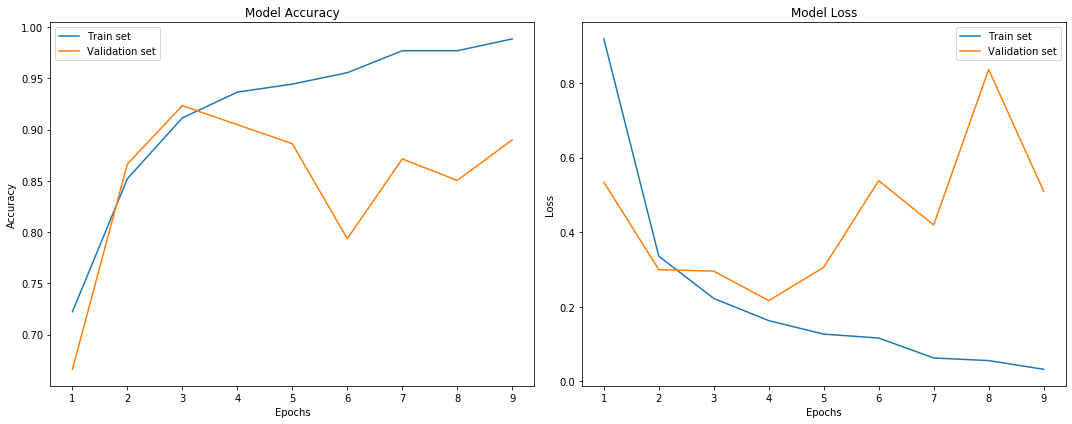

In [54]:
plotPerformance(history5)

In [21]:
# The model starts overfitting between epoch 2-3

In [11]:
# define a smaller patience for Early Stopping
def trainEarlyStoppingPatience2(model, trainGenerator, valGenerator, saveFile):
    # use EarlyStopping - stop when the monitored metric(validation accuracy) is no longer improving
    earlyStopping = EarlyStopping(
                    monitor = 'val_acc',
                    mode = 'max',
                    patience = 0)
    history = model.fit_generator(
            trainGenerator,
            epochs = 50,
            validation_data = valGenerator,
            callbacks = [earlyStopping])
    model.save(saveFile)
    
    return history

In [12]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model6 = brainModel2()
history6 = trainEarlyStoppingPatience2(model6, trainGeneratorAugES, valGeneratorAugES, 'model6')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 101s 663ms/step - loss: 0.9135 - acc: 0.7298 - val_loss: 0.5148 - val_acc: 0.6996
Epoch 2/50
152/152 [==============================] - 111s 730ms/step - loss: 0.3561 - acc: 0.8418 - val_loss: 0.2604 - val_acc: 0.9011
Epoch 3/50
152/152 [==============================] - 116s 765ms/step - loss: 0.2376 - acc: 0.9020 - val_loss: 0.3610 - val_acc: 0.9011


In [19]:
evaluateModel(model6, testGeneratorAugES)

Loss = 0.7335434626130497
Test Accuracy = 0.80641186


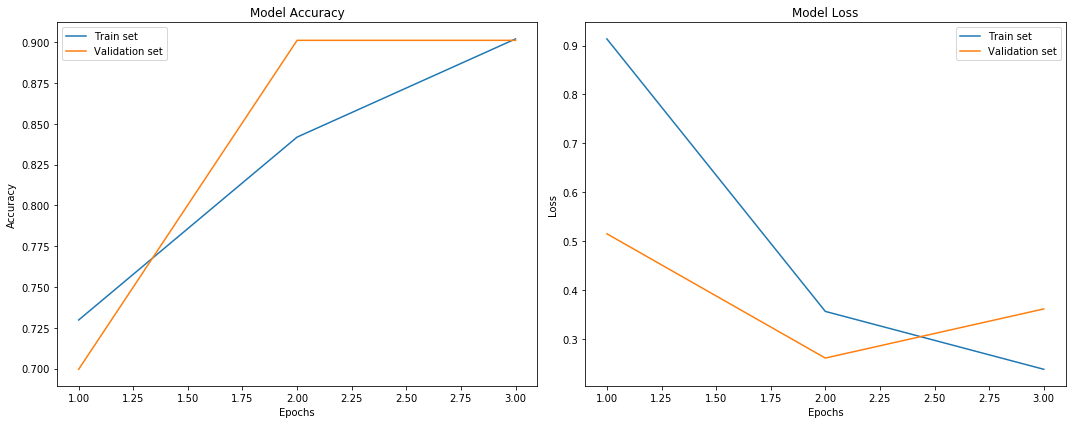

In [20]:
plotPerformance(history6)

In [24]:
# add L2 regularization to the model
def brainModel3():
    model = Sequential()
    model.add(Conv2D(96, kernel_size = (11, 11), strides = (4, 4), input_shape = (150, 150, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides = (2, 2)))
    
    model.add(Conv2D(256, kernel_size = (5, 5), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2,2)))
    
    model.add(Conv2D(384, kernel_size = (3, 3), strides = (1, 1), padding = "same", kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(384, kernel_size = (1, 1), strides = (1, 1), padding = "same", kernel_regularizer = tf.keras.regularizers.l2(l=0.01)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size = (1, 1), strides = (1, 1), padding = "same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2,2)))
    
    # add the fully-connected layers
    model.add(Flatten())
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
    
    return model

In [31]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model7 = brainModel3()
history7 = trainEarlyStoppingPatience2(model7, trainGeneratorAugES, valGeneratorAugES, 'model7')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 133s 875ms/step - loss: 9.0074 - acc: 0.6812 - val_loss: 7.1027 - val_acc: 0.6415
Epoch 2/50
152/152 [==============================] - 134s 879ms/step - loss: 6.6908 - acc: 0.8456 - val_loss: 6.3711 - val_acc: 0.8999
Epoch 3/50
152/152 [==============================] - 167s 1s/step - loss: 6.2237 - acc: 0.8834 - val_loss: 6.0953 - val_acc: 0.8949


In [32]:
evaluateModel(model7, testGeneratorAugES)

Loss = 6.5301944321277094
Test Accuracy = 0.8236745


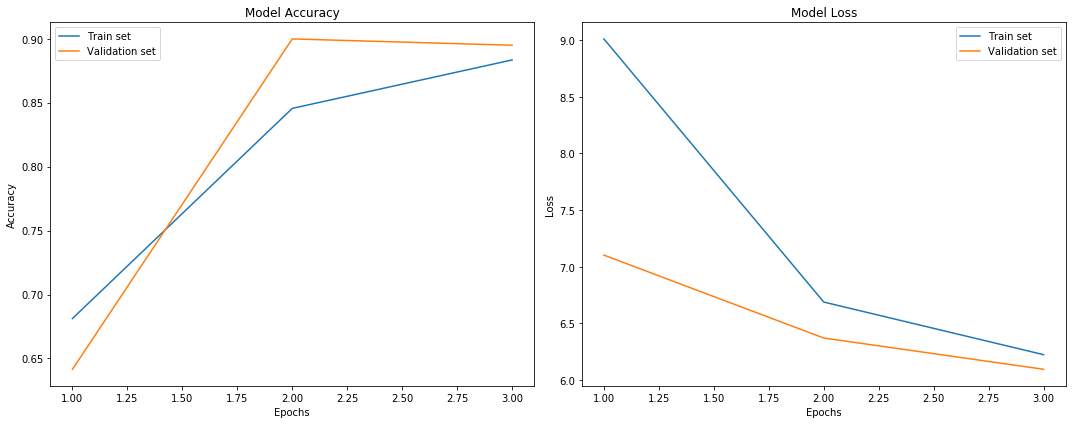

In [33]:
plotPerformance(history7)

class prediction (% tumor) = 
0.18458371
Classified as NO


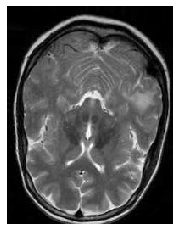

In [34]:
image_path_no = TEST_SET_AUG_2 + 'no/aug_N_0_480.jpg'
predictImage(model7, image_path_no)

class prediction (% tumor) = 
0.9999852
Classified as YES


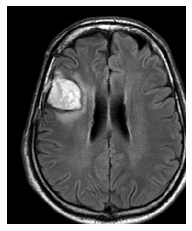

In [35]:
image_path_yes = TEST_SET_AUG_2 + 'yes/aug_Y_0_785.jpg'
predictImage(model7, image_path_yes)

In [38]:
trainGeneratorAugES, valGeneratorAugES, testGeneratorAugES = loadData(TRAIN_SET_AUG_2, VAL_SET_AUG_2, TEST_SET_AUG_2)
model8 = brainModel3()
history8 = trainEarlyStoppingValLoss(model8, trainGeneratorAugES, valGeneratorAugES, 'model8')

Found 2428 images belonging to 2 classes.
Found 809 images belonging to 2 classes.
Found 811 images belonging to 2 classes.
Epoch 1/50
152/152 [==============================] - 163s 1s/step - loss: 7.5567 - acc: 0.7376 - val_loss: 7.0361 - val_acc: 0.6848
Epoch 2/50
152/152 [==============================] - 166s 1s/step - loss: 6.7043 - acc: 0.8451 - val_loss: 6.5364 - val_acc: 0.8072
Epoch 3/50
152/152 [==============================] - 139s 912ms/step - loss: 6.2067 - acc: 0.9007 - val_loss: 6.0203 - val_acc: 0.9085
Epoch 4/50
152/152 [==============================] - 120s 790ms/step - loss: 5.8168 - acc: 0.9230 - val_loss: 5.9463 - val_acc: 0.8121
Epoch 5/50
152/152 [==============================] - 136s 892ms/step - loss: 5.4437 - acc: 0.9419 - val_loss: 5.4998 - val_acc: 0.8603
Epoch 6/50
152/152 [==============================] - 147s 967ms/step - loss: 5.0863 - acc: 0.9646 - val_loss: 5.4133 - val_acc: 0.8492
Epoch 7/50
152/152 [==============================] - 127s 834ms/s

In [39]:
evaluateModel(model8, testGeneratorAugES)

Loss = 1.4517936537078782
Test Accuracy = 0.89025897


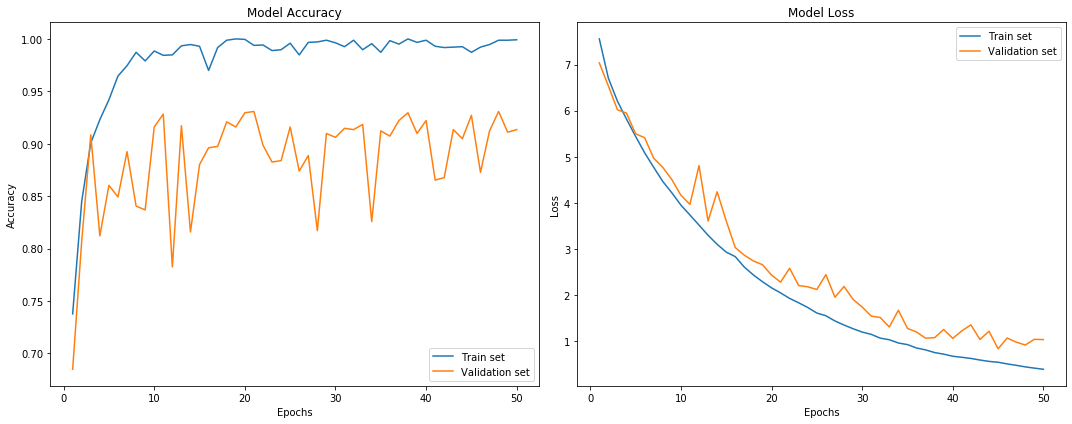

In [40]:
plotPerformance(history8)

class prediction (% tumor) = 
1.5549028e-06
Classified as NO


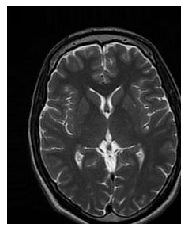

In [41]:
image_path_no = TEST_SET_AUG_2 + 'no/aug_N_0_292.jpg'
predictImage(model8, image_path_no)

class prediction (% tumor) = 
1.0
Classified as YES


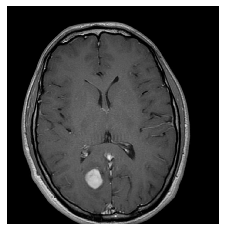

In [42]:
image_path_yes = TEST_SET_AUG_2 + 'yes/aug_Y_0_1637.jpg'
predictImage(model8, image_path_yes)